<a href="https://colab.research.google.com/github/mimi-1/DataProjects/blob/main/MLProject.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Credit risk analysis 

dataset :  https://www.openml.org/search?type=data&status=active&id=31

some links to delete later
https://mljar.com/machine-learning/use-case/credit-g/

https://online.stat.psu.edu/stat857/node/217/

**Process**
 1. Clean, convert binary to strings, remove and impute NA
 2. Explore to find dependencies and distributions to make decisions
 3. Normalize numeric features
 3. Encode ordinal variables to preserve the perceived distance 
 4. Encode nominal variables (Weight of Evidence methods )
 5. Rescale everything to positives as required by some algorithms 
 6. Use automatic feature selection by applying a Random forest classifier (Not sure as we don't have a lot of variables now) 
 6. Define cost function to tune classifiers and 
 7. For each selected algorithm, tune parameters. For some, tune thresholds
 8. Compare chosen classifiers, and build a ROC curve plot. 
 9. Make a winner

## Setup and read data 

In [1]:
import pandas as pd
from scipy.io import arff
import numpy as np

import urllib.request
import io # for io.StringIO()

# ML libraries
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import NearestNeighbors , KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier



from sklearn.model_selection import train_test_split , cross_val_score , GridSearchCV
import sklearn.preprocessing as preprocessing

#Hyperparameters tuning i
from sklearn.model_selection import train_test_split , cross_val_score , GridSearchCV
import sklearn.metrics as metrics 

#Visualization library 
import matplotlib.pylab as plt
import seaborn as sns
%matplotlib inline

# !pip install dmba
# from dmba import plotDecisionTree, classificationSummary, regressionSummary


sns.set_style("darkgrid")
sns.set_palette('deep')
colors = sns.color_palette('deep')

#  display enhancement 
from IPython.display import Markdown, display
#function to print markdown
def printmd(string):
    display(Markdown(string))

In [2]:
# Load ARFF file into a pandas dataframe
# data from https://www.openml.org/search?type=data&status=active&id=31
# data, meta = arff.loadarff('dataset_31_credit-g.arff')



url = r'https://raw.githubusercontent.com/mimi-1/Datasets/main/dataset_31_credit-g.arff'
ftpstream = urllib.request.urlopen(url)
data, meta = arff.loadarff(io.StringIO(ftpstream.read().decode('utf-8')))

df = pd.DataFrame(data)
df.sample(3)

,checking_status,duration,credit_history,purpose,credit_amount,savings_status,employment,installment_commitment,personal_status,other_parties,...,property_magnitude,age,other_payment_plans,housing,existing_credits,job,num_dependents,own_telephone,foreign_worker,class
473,b'no checking',6.0,b'existing paid',b'retraining',1238.0,b'no known savings',b'unemployed',4.0,b'male single',b'none',...,b'life insurance',36.0,b'none',b'own',1.0,b'high qualif/self emp/mgmt',2.0,b'yes',b'yes',b'good'
421,b'0<=X<200',12.0,b'existing paid',b'used car',2028.0,b'no known savings',b'1<=X<4',4.0,b'male single',b'none',...,b'car',30.0,b'none',b'own',1.0,b'skilled',1.0,b'none',b'yes',b'good'
748,b'no checking',21.0,b'existing paid',b'used car',5248.0,b'no known savings',b'1<=X<4',1.0,b'male single',b'none',...,b'car',26.0,b'none',b'own',1.0,b'skilled',1.0,b'none',b'yes',b'good'


### Read metadata and decode binary
*meta* contains information about dataset
There are binary data instead of strings which we will encode in the next blocks of code

In [3]:
#decoding string values from binary to string in all columns that have 'object' datatype
# function to check if a column is binary
def is_binary(data):
    return all(isinstance(x, (bytes, bytearray)) for x in data)

for col in df.columns:
  if is_binary(df[col]): 
     df[col] = df[col].str.decode('utf-8')  
df.head(4)

,checking_status,duration,credit_history,purpose,credit_amount,savings_status,employment,installment_commitment,personal_status,other_parties,...,property_magnitude,age,other_payment_plans,housing,existing_credits,job,num_dependents,own_telephone,foreign_worker,class
0,<0,6.0,critical/other existing credit,radio/tv,1169.0,no known savings,>=7,4.0,male single,none,...,real estate,67.0,none,own,2.0,skilled,1.0,yes,yes,good
1,0<=X<200,48.0,existing paid,radio/tv,5951.0,<100,1<=X<4,2.0,female div/dep/mar,none,...,real estate,22.0,none,own,1.0,skilled,1.0,none,yes,bad
2,no checking,12.0,critical/other existing credit,education,2096.0,<100,4<=X<7,2.0,male single,none,...,real estate,49.0,none,own,1.0,unskilled resident,2.0,none,yes,good
3,<0,42.0,existing paid,furniture/equipment,7882.0,<100,4<=X<7,2.0,male single,guarantor,...,life insurance,45.0,none,for free,1.0,skilled,2.0,none,yes,good


In [4]:
#meta contains metainformation about dataset
# print(meta)
# turning it into dictionary #
attribute_names = meta.names()
attribute_types = meta.types()
# Create dictonary with attribute names and types
var_dict = {}
for name, type_ in zip(attribute_names, attribute_types):
    var_dict[name]=type_
var_dict

{'checking_status': 'nominal',
 'duration': 'numeric',
 'credit_history': 'nominal',
 'purpose': 'nominal',
 'credit_amount': 'numeric',
 'savings_status': 'nominal',
 'employment': 'nominal',
 'installment_commitment': 'numeric',
 'personal_status': 'nominal',
 'other_parties': 'nominal',
 'residence_since': 'numeric',
 'property_magnitude': 'nominal',
 'age': 'numeric',
 'other_payment_plans': 'nominal',
 'housing': 'nominal',
 'existing_credits': 'numeric',
 'job': 'nominal',
 'num_dependents': 'numeric',
 'own_telephone': 'nominal',
 'foreign_worker': 'nominal',
 'class': 'nominal'}

## Exploration

#### Distribution of the target

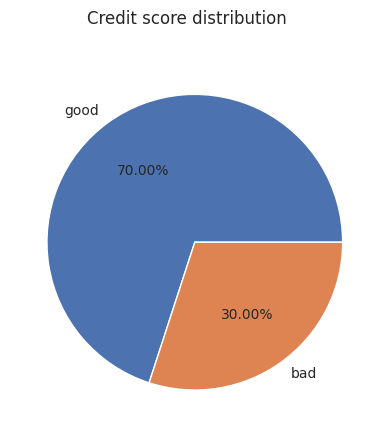

In [5]:
# What is the distribution of our output
# print(df['class'].value_counts())
plt.pie(df['class'].value_counts(),labels = ['good','bad'],colors=colors, autopct='%1.2f%%')
plt.suptitle("Credit score distribution")
plt.show()


#### Predictors

In [6]:
nominal_vars = [k for k, v in var_dict.items() if v == 'nominal']
numeric_vars = [k for k, v in var_dict.items() if v == 'numeric']
print("Nominal variables: ", len(nominal_vars))
print(nominal_vars)
print("\nNumeric variables: ", len(numeric_vars))
print(numeric_vars)

Nominal variables:  14
['checking_status', 'credit_history', 'purpose', 'savings_status', 'employment', 'personal_status', 'other_parties', 'property_magnitude', 'other_payment_plans', 'housing', 'job', 'own_telephone', 'foreign_worker', 'class']

Numeric variables:  7
['duration', 'credit_amount', 'installment_commitment', 'residence_since', 'age', 'existing_credits', 'num_dependents']


#### EDA Numerical variables


In [7]:
df.describe()

,duration,credit_amount,installment_commitment,residence_since,age,existing_credits,num_dependents
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,20.903000,3271.258000,2.973000,2.845000,35.546000,1.407000,1.155000
std,12.058814,2822.736876,1.118715,1.103718,11.375469,0.577654,0.362086
min,4.000000,250.000000,1.000000,1.000000,19.000000,1.000000,1.000000
25%,12.000000,1365.500000,2.000000,2.000000,27.000000,1.000000,1.000000
50%,18.000000,2319.500000,3.000000,3.000000,33.000000,1.000000,1.000000
75%,24.000000,3972.250000,4.000000,4.000000,42.000000,2.000000,1.000000
max,72.000000,18424.000000,4.000000,4.000000,75.000000,4.000000,2.000000


We will treat variables installment_commitment, residence_since, num_dependents and existing_credits as ordinal categorical because they contain limited amount of descrete values. 

see *ordinal_vars* 

**DTA Continous numerical variables**

In [8]:
ordinal_vars = ['installment_commitment', 'residence_since', 'num_dependents' , 'existing_credits']
numeric_vars = list(set(numeric_vars)-set(ordinal_vars))
numeric_vars

# normalizing 

['age', 'duration', 'credit_amount']

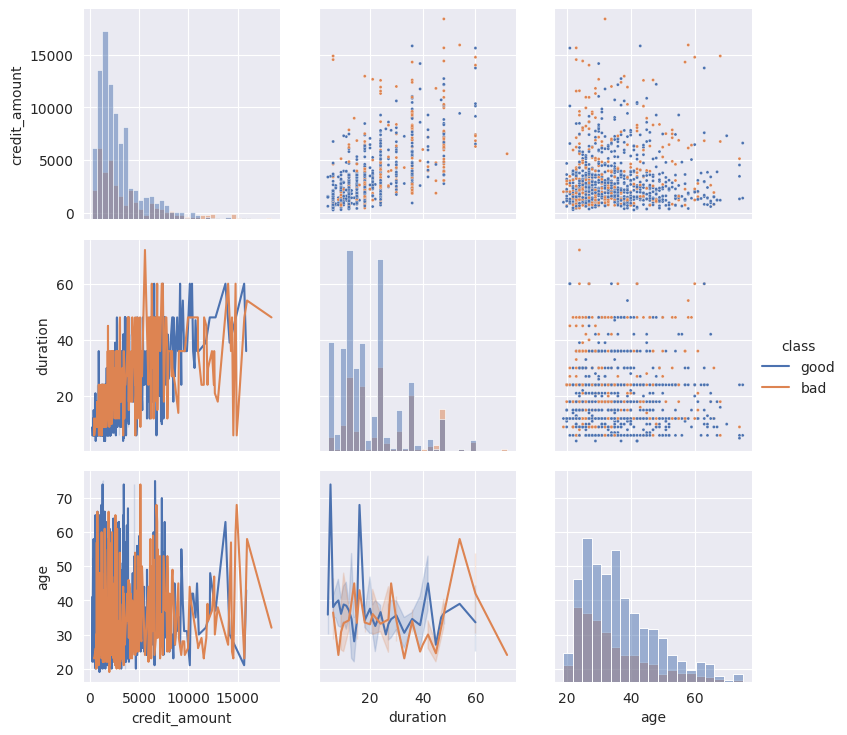

In [9]:
# Distributions of continous numerical variable 
g = sns.PairGrid(df[['credit_amount','duration','age','class']], hue="class")
g.map_upper(sns.scatterplot, s=5)
g.map_lower(sns.lineplot)
g.map_diag(sns.histplot)
g.add_legend()

In [10]:
# all numaric are left skewed with outlayers, so we will bin them to improve the robustness of the model.

In [11]:
# there is possible correlation between credit amount and duration 

printmd("Pearson correlation betweeen credit amount and duration")
df[['credit_amount','duration']].corr()



Pearson correlation betweeen credit amount and duration

,credit_amount,duration
credit_amount,1.000000,0.624984
duration,0.624984,1.000000


Notes on considering PCA to reduce dimensions.  

Features *duration* and *credit-amount* are positively correlated with a Pearson coefficient greater than 0.6. However, upon closer inspection, we can observe that there are some uncorrelated values in the higher ranges of *credit-amount* for bad credits, and this occurs across the range of *duration*. We do not wish to lose this information, and therefore we have decided not to use Principal Component Analysis (PCA) as a dimensionality reduction technique.


In [12]:
# as we are going to use logistic regression as one of our methods, we normalize our numeric variables
# and keep them in columns with "_norm" suffix

for var in numeric_vars:
  df[var + '_norm'] = (df[var] - df[var] .mean()) / df[var].std()
  
df.mean()
# df['credit_amount_norm'] = (df['credit_amount'] - df['credit_amount'] .mean()) / df['credit_amount'].std()

<ipython-input-12-fdca89258b0d>:7: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  df.mean()


duration                  2.090300e+01
credit_amount             3.271258e+03
installment_commitment    2.973000e+00
residence_since           2.845000e+00
age                       3.554600e+01
existing_credits          1.407000e+00
num_dependents            1.155000e+00
age_norm                  4.973799e-17
duration_norm             1.563194e-16
credit_amount_norm        7.371881e-17
dtype: float64

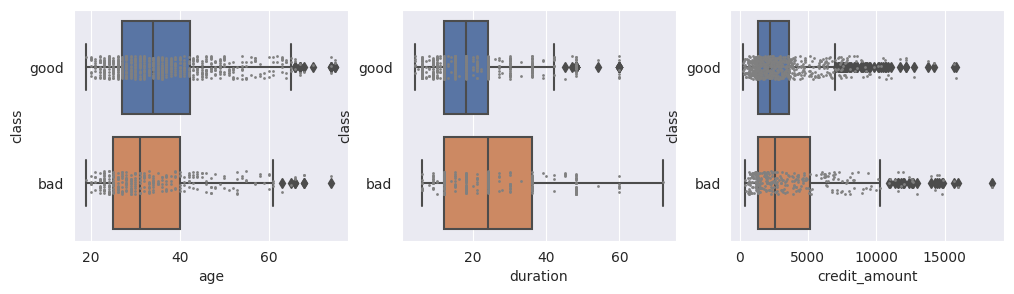

In [13]:
# BoxPlot 

# fig, (ax1, ax2, ax3) = plt.subplots(1, 3,figsize=(12,3))

fig, axes = plt.subplots(1, 3,figsize=(12,3))
ax_n=0
for var in numeric_vars:
  sns.boxplot(data=df, x=var, y="class",ax=axes[ax_n])
  sns.stripplot(data=df, x=var, y="class",ax=axes[ax_n] , jitter=True, color='grey', s=2)
  ax_n = ax_n + 1

plt.show()


age    19.0  20.0  21.0  22.0  23.0  24.0  25.0  26.0  27.0  28.0  ...  62.0  \
class                                                              ...         
bad     0.5  0.36  0.36  0.41  0.42  0.43  0.46  0.28  0.25  0.35  ...   0.0   
good    0.5  0.64  0.64  0.59  0.58  0.57  0.54  0.72  0.75  0.65  ...   1.0   

age    63.0  64.0  65.0  66.0  67.0  68.0  70.0  74.0  75.0  
class                                                        
bad    0.12   0.0   0.2   0.4   0.0  0.67   0.0  0.25   0.0  
good   0.88   1.0   0.8   0.6   1.0  0.33   1.0  0.75   1.0  

[2 rows x 53 columns]


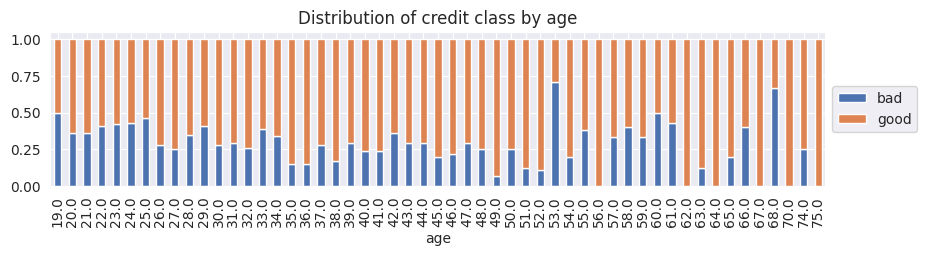

In [14]:
# Explore distribution of age variable through bad and good credit 
tb = pd.crosstab(df['class'], df['age'])
probTb = round(tb/tb.sum(),2)
print(probTb)
# plot the ratios in a stacked bar chart
ax = probTb.transpose().plot(kind='bar', stacked=True, figsize=(10,2))
plt.title('Distribution of credit class by age')
plt.legend(loc='center left',bbox_to_anchor=(1, 0.5))
plt.show()

### Binning numerical variables.   
Benefits: 
* account for outliers
* simplify model
* unify measurement of distance
Downfalls: 
 * losing information
 * reweighing data and introducing arbitrariness by means of the chosen number of bins

Binning decision are based on literature review:  
* Age: youths (18-24), young working age (25-34), lower middle working age (35-44), upper middle working age (45-54), senior working age (55-64) and Seniors (>=65).
* duration: less than 1 year, 1-3 years, 3-5 years, 5-7 years, 7-10 years, and 10 years or more
* credit_amount: Less than $1,000, $1,000-$5,000, $5,000-$10,000, $10,000-$25,000, $25,000-$50,000, and $50,000 and above.


Age mim  19.0 Age maximum  75.0


<Axes: xlabel='age', ylabel='Count'>

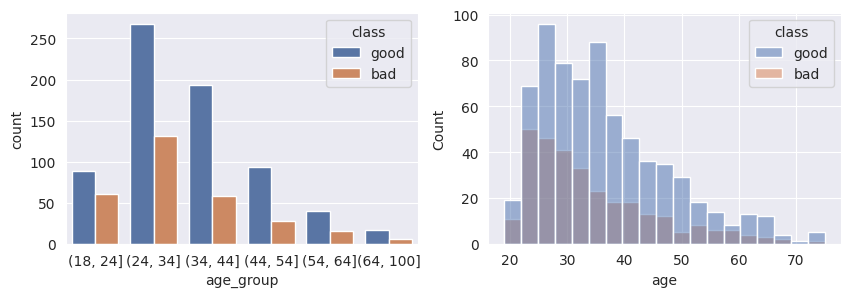

In [15]:
# binning age https://www.statcan.gc.ca/en/concepts/definitions/age2
print("Age mim ", df.age.min(), "Age maximum ", df.age.max())

# print(np.sort(df.age.unique()))

# print("Good:\n", df[df['class']=="good"].age.quantile(q=[0.25,0.5,0.75]))
# print("Bad:\n",df[df['class']=="bad"].age.quantile(q=[0.25,0.5,0.75]))

age_bins=[18,24,34,44,54,64,100]
df['age_group'] = pd.cut(df.age,age_bins)
# df[['age','age_groups']].head(5)

#Distribution of age by 
fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(10,3))
sns.countplot(data=df,x='age_group', hue='class', ax= ax1)
sns.histplot(data=df,x='age', hue='class', ax= ax2)

<Axes: xlabel='duration', ylabel='Count'>

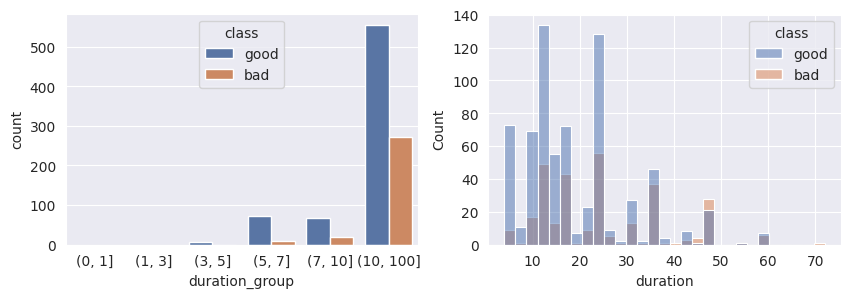

In [16]:
#Binning duration

# duration: less than 1 year, 1-3 years, 3-5 years, 5-7 years, 7-10 years, and 10 years or more

duration_bins=[0,1,3,5,7,10,100]
df['duration_group'] = pd.cut(df.duration,duration_bins)
# df[['duration','duration_groups']].head(5)

# #Distribution of age by 
fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(10,3))
sns.countplot(data=df,x='duration_group', hue='class', ax= ax1)
sns.histplot(data=df,x='duration', hue='class', ax= ax2)

# Those are bad bins 


<Axes: xlabel='credit_amount', ylabel='Count'>

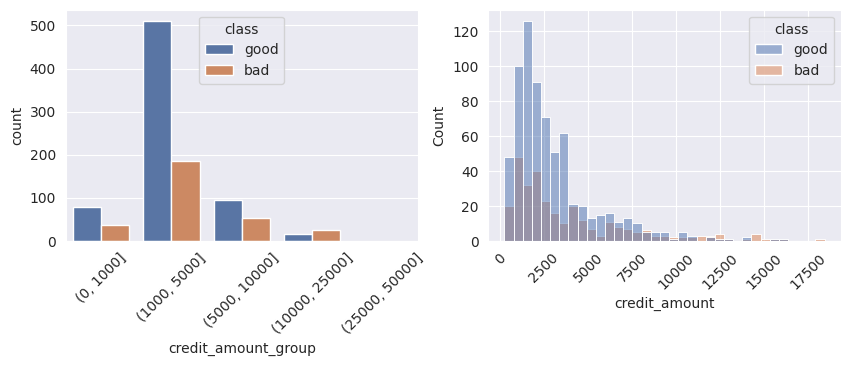

In [17]:
#Bining credit amount
# credit_amount: Less than  1,000, 1,000- 5,000, 5,000- 10,000, 10,000- 25,000, 25,000- 50,000,𝑎𝑛𝑑 50,000 and above.

amount_bins=[0,1000,5000,10000,25000,50000]
df['credit_amount_group'] = pd.cut(df.credit_amount,amount_bins)
# df[['duration','duration_groups']].head(5)

# #Distribution of age by 
fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(10,3))
plt.xticks(rotation = 45) 
cntplt = sns.countplot(data=df,x='credit_amount_group', hue='class', ax= ax1)
cntplt.tick_params(axis='x', labelrotation = 45)
sns.histplot(data=df,x='credit_amount', hue='class', ax= ax2)



### Categorical variables: nominal and ordinal

#### Explore cardinality and distribution of categorical variables

In [18]:
printmd("**Nominal features values:**")
n=0
l = 0
for var in nominal_vars:
    printmd("*"+var+"*")
    print("  ", df[var].unique())
    n+=1
    l = l+ df[var].unique().size
    
printmd("**Estimating amount of variables after one-hot encoding**")
printmd("Number of categorical variables in the dataset "+str(n))
printmd("Total amount of unique values "+str(l))
printmd("Estimate Number of new features after one-hot encoding with drop-one is  "+str(l-n))


**Nominal features values:**

*checking_status*

   ['<0' '0<=X<200' 'no checking' '>=200']


*credit_history*

   ['critical/other existing credit' 'existing paid' 'delayed previously'
 'no credits/all paid' 'all paid']


*purpose*

   ['radio/tv' 'education' 'furniture/equipment' 'new car' 'used car'
 'business' 'domestic appliance' 'repairs' 'other' 'retraining']


*savings_status*

   ['no known savings' '<100' '500<=X<1000' '>=1000' '100<=X<500']


*employment*

   ['>=7' '1<=X<4' '4<=X<7' 'unemployed' '<1']


*personal_status*

   ['male single' 'female div/dep/mar' 'male div/sep' 'male mar/wid']


*other_parties*

   ['none' 'guarantor' 'co applicant']


*property_magnitude*

   ['real estate' 'life insurance' 'no known property' 'car']


*other_payment_plans*

   ['none' 'bank' 'stores']


*housing*

   ['own' 'for free' 'rent']


*job*

   ['skilled' 'unskilled resident' 'high qualif/self emp/mgmt'
 'unemp/unskilled non res']


*own_telephone*

   ['yes' 'none']


*foreign_worker*

   ['yes' 'no']


*class*

   ['good' 'bad']


**Estimating amount of variables after one-hot encoding**

Number of categorical variables in the dataset 14

Total amount of unique values 56

Estimate Number of new features after one-hot encoding with drop-one is  42

In [19]:
nominal_vars.remove("class")
categorical_vars=nominal_vars+ordinal_vars


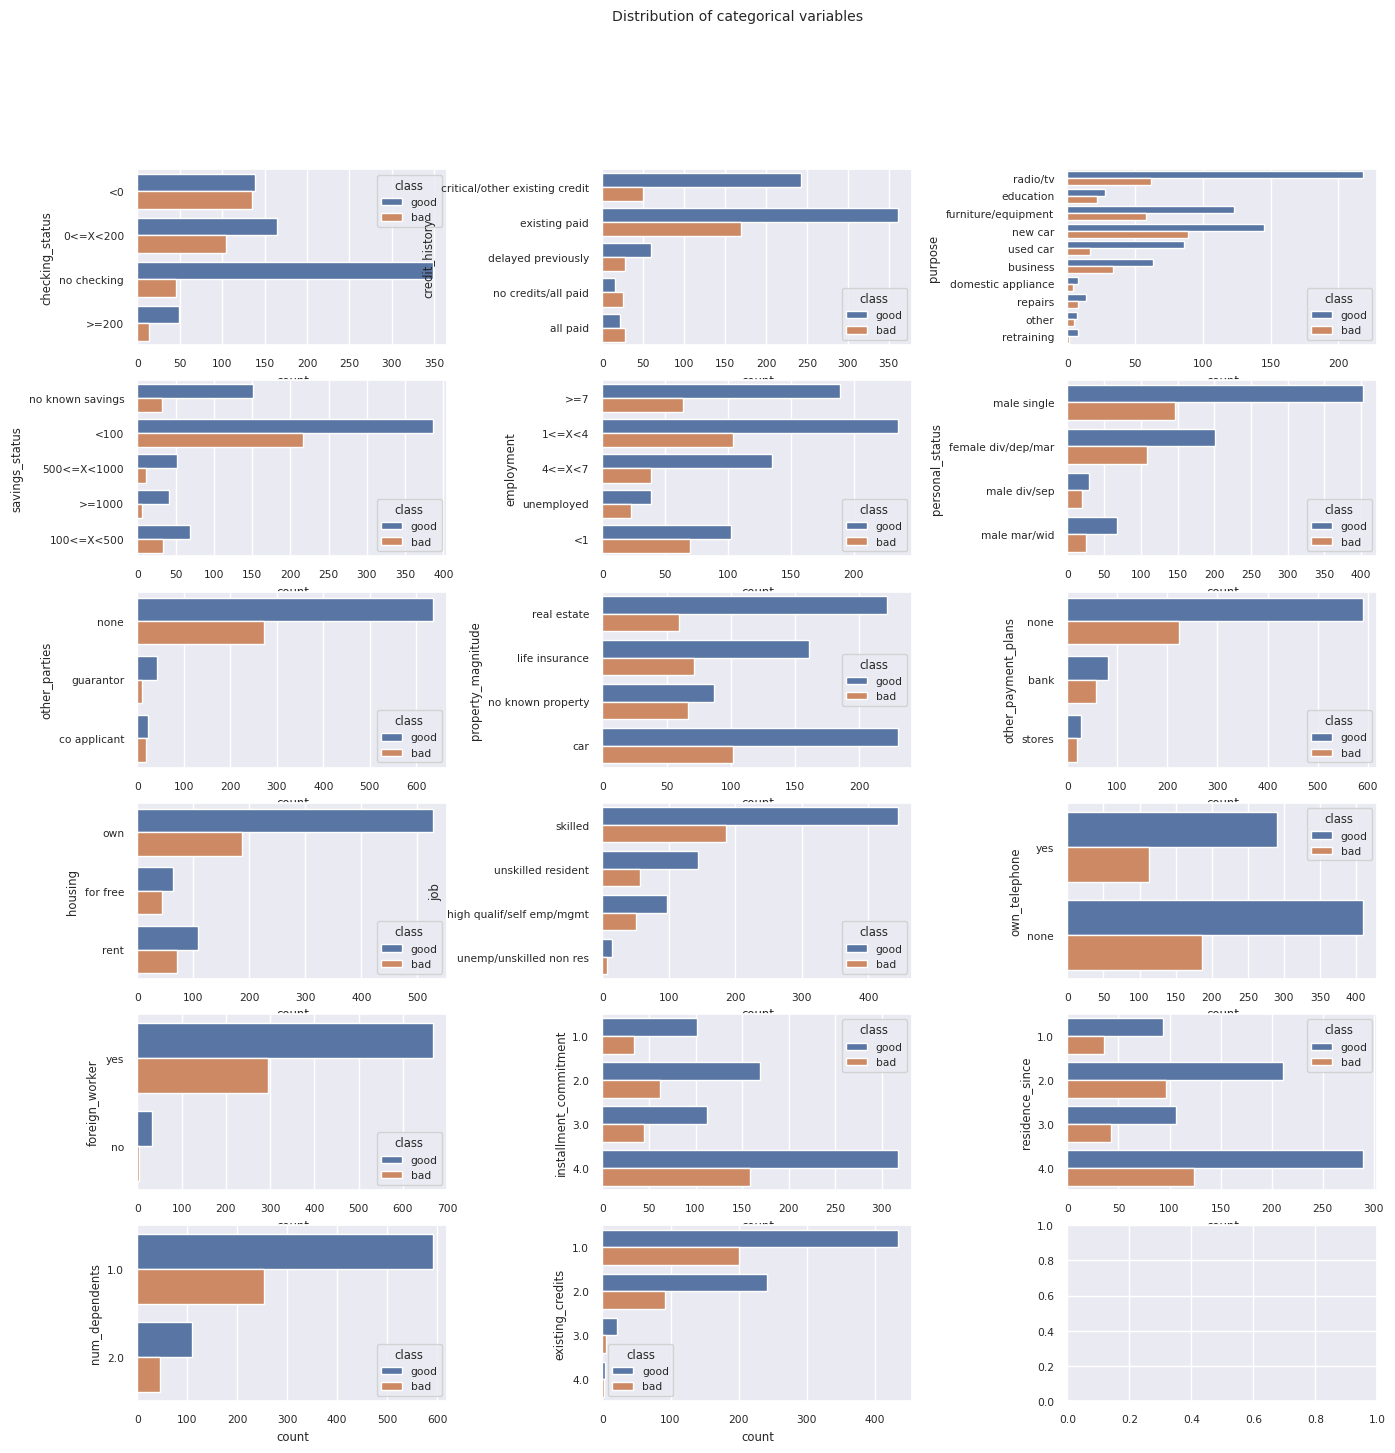

In [20]:
# visualize distribution of categorical varables

#nominal_vars
#ordinal_vars
sns.set(font_scale=0.7)
ncols=3
nrows=6
fig, axes = plt.subplots(nrows=nrows,ncols=ncols,figsize=(16,16))
col = 0
row = 0
for var in categorical_vars:
  sns.countplot(data=df, y=var, hue="class",ax=axes[row,col])
  col = (col + 1) if col<ncols-1 else 0
  row = row +1 if col == 0 else row
  
plt.subplots_adjust(wspace=0.5)
plt.suptitle("Distribution of categorical variables")
plt.show()


## Encoding Categorical variables

Research on encoding "Evaluating categorical encoding methods on a real credit card fraud
detection database" https://arxiv.org/pdf/2112.12024.pdf  


Sometimes the categories in a categorical variable represent intervals. Common examples are age group
or income bracket. If the interval values are known (e.g., category 2 is the age interval 20–30), we can
replace the categorical value (“2” in the example) with the mid-interval value (here “25”). The result will
be a numerical variable which no longer requires multiple dummy variables.

In [24]:
#Ordinal Label Encoding (Expert ordering between classes)
#resource: https://github.com/Rushi21-kesh/Feature-Engineering/blob/main/Handling%20Categorical%20Data/2.%20Ordinal%20Label%20Encoding%20Technique.ipynb
encode_ordinal={
    'savings_status':{
        'no known savings':0.0, 
        '<100':0.1,
        '500<=X<1000':0.75,
        '>=1000':1.0,
        '100<=X<500':0.5
    },
    'employment':{
        '>=7': 1,
        '1<=X<4': 0.25,
        '4<=X<7':0.55,
         '<1':0.1,
         'unemployed': 0.01,
        },
        'property_magnitude': {
            'real estate':1, 
            'life insurance':0.75, 
            'no known property':0.01,
             'car':0.25,
             },
        'housing': {
            'own':1,
            'for free':0,
            'rent':0.5,
        },
        'job':{
            'skilled':0.8, 
            'unskilled resident':0, 
            'high qualif/self emp/mgmt':1,
            'unemp/unskilled non res':0
            },
        'class':{
            'good':0,
            'bad':1
        }  
}
ordinal_encoded =  [el+"_encoded" for el in encode_ordinal.keys()]
for var in encode_ordinal.keys():
  encoding_dict = encode_ordinal[var]
  df[var+'_encoded'] = df[var].map(encoding_dict)

ordinal_vars.extend(ordinal_encoded)
ordinal_vars.remove('class_encoded')
print("List of all ordinal predictors: ")
print(ordinal_vars)
df[['class','class_encoded']].sample(9)

List of all ordinal predictors: 
['installment_commitment', 'residence_since', 'num_dependents', 'existing_credits', 'savings_status_encoded', 'employment_encoded', 'property_magnitude_encoded', 'housing_encoded', 'job_encoded']


,class,class_encoded
649,bad,1
963,bad,1
726,good,0
62,bad,1
175,bad,1
613,good,0
931,bad,1
800,good,0
56,bad,1


**Nominal variables Encoding**  

Weight of Evidence shows the best result in fraud detection.
https://arxiv.org/pdf/2112.12024.pdf

$$WOE = ln(\dfrac{\%good}{\%bad})$$

In [25]:

#Nominal encoding Weight of Evidence shows the best result in fraud detection, so we use it for our nominal variables
# while checking_status is ordinal, it contains over 50% of unchecked data which indicates good credit way more then other categories, so we decided to use WOE method
cols_encode_WOE = ['checking_status','credit_history','purpose','personal_status','other_parties','other_payment_plans']

# purpose_labels = df.groupby(['purpose'])['class_encoded'].mean().sort_values()

# purpose_labels = df.groupby(['purpose'])['class_encoded'].aggregate(['mean','sum','count']) #ln(event%/non-event%)
total_good = df['class'].value_counts()['good']
total_bad = df['class'].value_counts()['bad']

for var in cols_encode_WOE:
  var_labels = df.groupby(var)['class'].value_counts().unstack()
  var_labels['good'] = 100 * var_labels['good'] / total_good
  var_labels['bad'] = 100* var_labels['bad'] / total_bad
  var_labels['WOE'] = round(np.log(var_labels['good'] / var_labels['bad']),4)
  var_decode_dict = var_labels['WOE'].to_dict()
  #encoding
  df[var+'_encoded'] = df[var].map(var_decode_dict)

# we dont include 'foreign worked as biased and own_telephon as obsolete,  num_dependents,  according to bar graph they dont carry a lot of information( equal distribution relatively to outcome)

nomial_encoded_vars = [el+'_encoded' for el in cols_encode_WOE]
nomial_encoded_vars



['checking_status_encoded',
 'credit_history_encoded',
 'purpose_encoded',
 'personal_status_encoded',
 'other_parties_encoded',
 'other_payment_plans_encoded']

In [26]:
from seaborn.axisgrid import categorical_order
# forming predictor list out of previously normalized numeric, ordinal and nominal vars
# predictors
numeric_vars_norm = [el+'_norm' for el in numeric_vars]
numeric_vars_norm



# we will use mixed numerinc and encoded nominal variables 
predictors = numeric_vars_norm + ordinal_encoded + nomial_encoded_vars
outcome = 'class'
print(len(predictors))
predictors.remove('class_encoded')
predictors

15


['age_norm',
 'duration_norm',
 'credit_amount_norm',
 'savings_status_encoded',
 'employment_encoded',
 'property_magnitude_encoded',
 'housing_encoded',
 'job_encoded',
 'checking_status_encoded',
 'credit_history_encoded',
 'purpose_encoded',
 'personal_status_encoded',
 'other_parties_encoded',
 'other_payment_plans_encoded']

In [27]:
df[predictors].describe()


,age_norm,duration_norm,credit_amount_norm,savings_status_encoded,employment_encoded,property_magnitude_encoded,housing_encoded,job_encoded,checking_status_encoded,credit_history_encoded,purpose_encoded,personal_status_encoded,other_parties_encoded,other_payment_plans_encoded
count,1.000000e+03,1.000000e+03,1.000000e+03,1000.00000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,4.973799e-17,1.563194e-16,7.371881e-17,0.20705,0.451270,0.540540,0.802500,0.652000,0.156873,0.050739,0.037289,0.008403,0.006329,0.009840
std,1.000000e+00,1.000000e+00,1.000000e+00,0.26911,0.353595,0.375797,0.337428,0.355278,0.870865,0.545088,0.426407,0.208975,0.181185,0.233123
min,-1.454533e+00,-1.401713e+00,-1.070329e+00,0.00000,0.010000,0.010000,0.000000,0.000000,-0.818100,-1.358100,-0.606100,-0.441800,-0.602200,-0.483600
25%,-7.512658e-01,-7.382981e-01,-6.751455e-01,0.10000,0.250000,0.250000,0.500000,0.800000,-0.818100,-0.088300,-0.359200,-0.235300,0.000500,0.121200
50%,-2.238150e-01,-2.407368e-01,-3.371756e-01,0.10000,0.250000,0.750000,1.000000,0.800000,-0.401400,-0.088300,-0.095600,0.165500,0.000500,0.121200
75%,5.673612e-01,2.568246e-01,2.483377e-01,0.10000,1.000000,1.000000,1.000000,0.800000,1.176300,0.733700,0.410100,0.165500,0.000500,0.121200
max,3.468341e+00,4.237315e+00,5.368103e+00,1.00000,1.000000,1.000000,1.000000,1.000000,1.176300,0.733700,1.232100,0.165500,0.587800,0.121200


## Prepare and split dataset

In [60]:
# apparently MultinomialNB doesn't accept negatives 
# So, I will 
from sklearn.preprocessing import MinMaxScaler
# Apply the MinMaxScaler transformer
scaler = MinMaxScaler()

columns = df[predictors].columns
Xnp = scaler.fit_transform(df[predictors])
X = pd.DataFrame(Xnp, columns=columns)
outcome='class'
y = df[outcome]
#split 
train_X, valid_X, train_y, valid_y = train_test_split(X, y, test_size=0.4, random_state=1)

Index(['age_norm', 'duration_norm', 'credit_amount_norm',
       'savings_status_encoded', 'employment_encoded',
       'property_magnitude_encoded', 'checking_status_encoded',
       'credit_history_encoded', 'purpose_encoded'],
      dtype='object')

## Random Forest for feature selection

research : https://www.researchgate.net/publication/51913500_The_All_Relevant_Feature_Selection_using_Random_Forest

We will use random forest full classifier to select the most important features.
It works. Overalll models show better scoring.

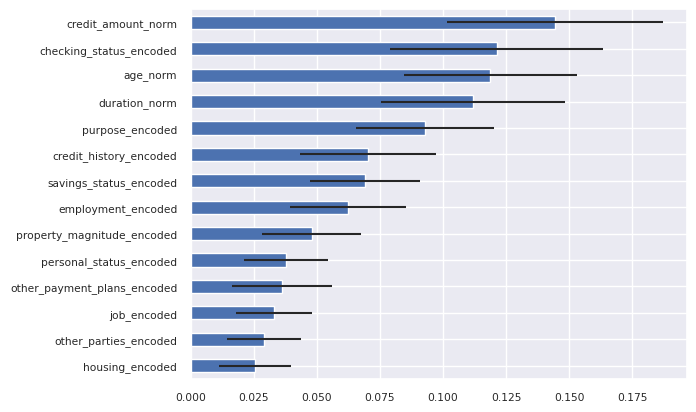

In [29]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel

# apply RF
rf = RandomForestClassifier(n_estimators=100, criterion = 'gini', class_weight= {"good":1, "bad":5},random_state=1) #90 is The number of trees in the forest.
rf.fit(train_X, train_y)

# # variable (feature) importance plot
importances = rf.feature_importances_
std = np.std([tree.feature_importances_ for tree in rf.estimators_], axis=0)

importance_df = pd.DataFrame({'feature': train_X.columns, 'importance': importances, 'std': std})
importance_df = importance_df.sort_values('importance')
# print(importance_df)
ax = importance_df.plot(kind='barh', xerr='std', x='feature', legend=False)
ax.set_ylabel('')
plt.show()

# classes = ['bad','good']
classes = rf.classes_

predict_y = rf.predict(valid_X)

# print("Classification metrics report")
# print(metrics.classification_report(valid_y, predict_y, labels=classes))

# cm = metrics.confusion_matrix(valid_y, predict_y, labels=classes)
# disp = metrics.ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
# disp.plot()

# Do ROC for features 

Random Forest fully classified the training set causing overfitting. It was necessary for feture selection. It wasnt run to estimate the accuracy and recall.

In [69]:
#Select featured 

threshold = np.sort(importances)[-10] #selecting first 9 features
print("Threshold:", threshold)
sfm = SelectFromModel(rf, threshold=threshold).fit(X, y)

selected_feat= train_X.columns[(sfm.get_support())]
print("Number of features selected: ", len(selected_feat))
all_predictors = predictors.copy()
predictors = list(selected_feat)
predictors
X=X[predictors]
# X.describe()
# Re-split data with 9 predictors 
train_X, valid_X, train_y, valid_y = train_test_split(X, y, test_size=0.4, random_state=1)

Threshold: 0.0377615123209747
Number of features selected:  9


# Utility Functions for tuning model parameters 

## Report function class_scoring

In [72]:
def class_scoring(cls, threshold=None):
  if threshold == None:  
    predict_y = cls.predict(valid_X)
    predict_train_y = cls.predict(train_X)
  else:
    train_probs = classNB_win.predict_proba(train_X) 
    probs = classNB_win.predict_proba(valid_X)
    predict_train_y = ['good' if x >= threshold else 'bad' for x in  train_probs[:, 1]]
    predict_y = ['good' if x >= threshold else 'bad' for x in  probs[:, 1]]


  print("Classification metrics report for training test")
  print(metrics.classification_report(train_y,predict_train_y,labels=classes))

  print("Classification metrics report for validation test")
  print(metrics.classification_report(valid_y, predict_y, labels=classes))

  print("**Model scoring**")
  print("Recall score: ", round(metrics.recall_score(valid_y, predict_y, pos_label= 'bad'),2))

  cost = cost_sensitive_score(valid_y, predict_y)
  print("Cost: ", cost)
  cm = metrics.confusion_matrix(valid_y, predict_y, labels=classes)
  disp = metrics.ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
  disp.plot()


## Cost sensitive scorer.
Cost of false good is 5 and cost of false bad is 1. Properly scored functions cost is 0.
We will use this scorer to tune parameters.
https://scikit-learn.org/stable/modules/cross_validation.html#cross-validation

In [73]:
#Define scorer 

def cost_sensitive_score(y_true, y_pred):
    cost_matrix = np.array([[0, 5], [1, 0]]) # Define the cost matrix
    tn, fp, fn, tp = metrics.confusion_matrix(y_true, y_pred,labels=classes).ravel()
    cost = cost_matrix[0,1] * fp + cost_matrix[1,0] * fn
    return cost

cost_sensitive_scorer = metrics.make_scorer(cost_sensitive_score, greater_is_better=False)

## ????? Need to define probability scorer too 

#CART DecisionTreeClassifier

In [66]:
# Grid Search with Cross Validation for DecisionTreeClassifer 

# Create the parameter grid based on the results of random search 
# see documentation for

params = {
    'criterion': ['gini', 'entropy', 'log_loss'], #The function to measure the quality of a split
    'max_depth': [2, 5, 7, 13, 30],
    'min_samples_split': [2, 8, 10, 12],  #The minimum number of samples required to split an internal node, we havew relatively small sample  of  0.6*1000 = 600 records
    'class_weight':[None, {"good":1, "bad":5},{"good":1, "bad":4},{"good":1, "bad":2} ]
}

# Create a based model
classTree = DecisionTreeClassifier()

# Instantiate the grid search model
grid_search = GridSearchCV(estimator = classTree, param_grid = params, verbose=1, scoring=cost_sensitive_scorer) #change verbose for more info
grid_search.fit(train_X, train_y)

classTree_param_win = grid_search.best_params_
classTree_win = best_grid = grid_search.best_estimator_ #returns classifier
print(classTree_win)

#Do I have to build ROC here? 


Fitting 5 folds for each of 240 candidates, totalling 1200 fits
DecisionTreeClassifier(class_weight={'bad': 4, 'good': 1}, max_depth=7,
                       min_samples_split=12)


Classification metrics report for training test
              precision    recall  f1-score   support

         bad       0.57      0.98      0.72       185
        good       0.99      0.67      0.80       415

    accuracy                           0.77       600
   macro avg       0.78      0.83      0.76       600
weighted avg       0.86      0.77      0.78       600

Classification metrics report for validation test
              precision    recall  f1-score   support

         bad       0.44      0.77      0.56       115
        good       0.87      0.60      0.71       285

    accuracy                           0.65       400
   macro avg       0.65      0.69      0.64       400
weighted avg       0.75      0.65      0.67       400

**Model scoring**
Recall score:  0.77
Cost:  243


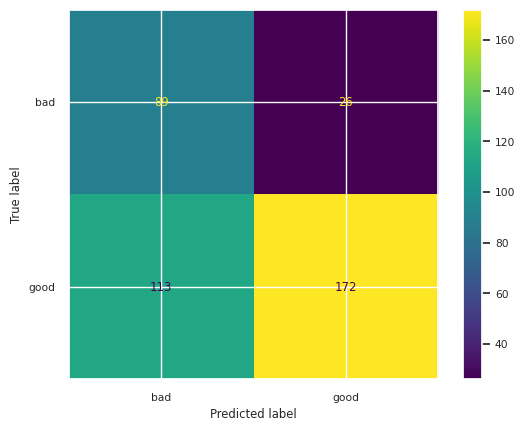

In [74]:
#scoring the model

# Scoring decision tree classification 
class_scoring(classTree_win)

### This is just to check the calculations , doesn't need to be run

In [ ]:
#Just checking the calculations
#cm is confusion matrix printed above 
# bad are our positives that require attention
trueBad = cm[0,0]  #TP
trueGood = cm[1,1]  #TN
falseBad =  cm[1,0]  #FP good loans classified as bad loans disturbing people and system with double check 
falseGood =  cm[0,1]  #FN bad loans classified as good loans people can get away 
print("false bad: ", falseBad)
print("false Good: ", falseGood)

accuracy = (trueBad+trueGood)/(trueBad+trueGood+falseGood+falseBad)
print("Accuracy: ", accuracy)

precision = (trueBad)/(trueBad + falseBad) # how many 
print("Precision: ", precision)

recall = (trueBad)/(trueBad + falseGood) # fraction of bad records identified correctly 
print("Recall: ", recall)

# Logistic regression 


In [38]:
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
## Tuning parameters for logistic regression 
# https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html


param_LR = {
    'penalty':['l1','l2'], #regularization to panish overfitting see documentation l1 - Lasso regularization, l2 - Ridge regularization. Adds some penalty to the cost functions
    'solver':['liblinear','saga'], # only chosing solvers supporting  regression 
    'C': [1e42],        # Inverse of regularization strength; must be a positive float 
    'class_weight':[None, {"good":1, "bad":5},{"good":1, "bad":4},{"good":1, "bad":2} ], #weight class for all models
}

# Create a based model
classLR = LogisticRegression()

# Instantiate the grid search model
grid_search = GridSearchCV(estimator = classLR, param_grid = param_LR, scoring=cost_sensitive_scorer)

grid_search.fit(train_X, train_y)
classLR_param_win = grid_search.best_params_
# print(classLR_param_win)
classLR_win = grid_search.best_estimator_ #returns classifier
print(classLR_win)

LogisticRegression(C=1e+42, class_weight={'bad': 5, 'good': 1}, penalty='l1',
                   solver='liblinear')


Classification metrics report for training test
              precision    recall  f1-score   support

         bad       0.45      0.89      0.60       185
        good       0.91      0.52      0.66       415

    accuracy                           0.63       600
   macro avg       0.68      0.70      0.63       600
weighted avg       0.77      0.63      0.64       600

Classification metrics report for validation test
              precision    recall  f1-score   support

         bad       0.43      0.90      0.59       115
        good       0.93      0.53      0.67       285

    accuracy                           0.64       400
   macro avg       0.68      0.71      0.63       400
weighted avg       0.78      0.64      0.65       400

**Model scoring**
Recall score:  0.9
Cost:  194


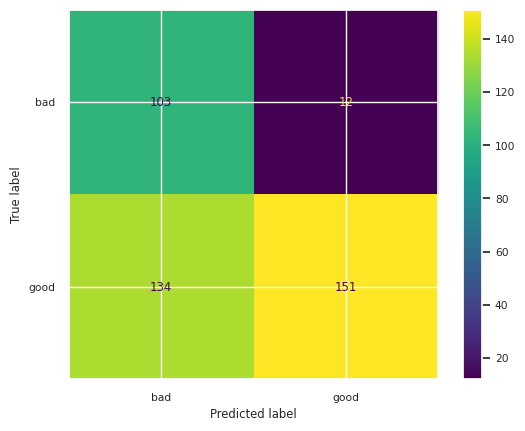

In [39]:
# Score the model 
class_scoring(classLR_win)

# Naive Bayes

For Naive Bayes, we will need different cost metrics that accounts threshols

In [40]:
## MultinomialNB requires all values to be positive which may not have a sence with this classifier becase decision will be made by probabilities
from sklearn.naive_bayes import MultinomialNB

#NB parameters 
params = {
    'alpha':np.logspace(-3,3, num=100), #Smoothing parameter for NB
}

# Create a based model
classNB = MultinomialNB(force_alpha=True)

# Instantiate the grid search model
grid_search = GridSearchCV(estimator = classNB, param_grid = params,  verbose=1, scoring=cost_sensitive_scorer)
grid_search.fit(train_X, train_y)

classNB_param_win = grid_search.best_params_
print(classNB_param_win)
classNB_win = grid_search.best_estimator_ #returns classifier


Fitting 5 folds for each of 100 candidates, totalling 500 fits
{'alpha': 0.001}


Classification metrics report for training test
              precision    recall  f1-score   support

         bad       0.43      0.81      0.56       185
        good       0.86      0.53      0.65       415

    accuracy                           0.61       600
   macro avg       0.65      0.67      0.61       600
weighted avg       0.73      0.61      0.63       600

Classification metrics report for validation test
              precision    recall  f1-score   support

         bad       0.43      0.85      0.57       115
        good       0.90      0.55      0.68       285

    accuracy                           0.64       400
   macro avg       0.67      0.70      0.63       400
weighted avg       0.77      0.64      0.65       400

**Model scoring**
Recall score:  0.85
Cost:  213


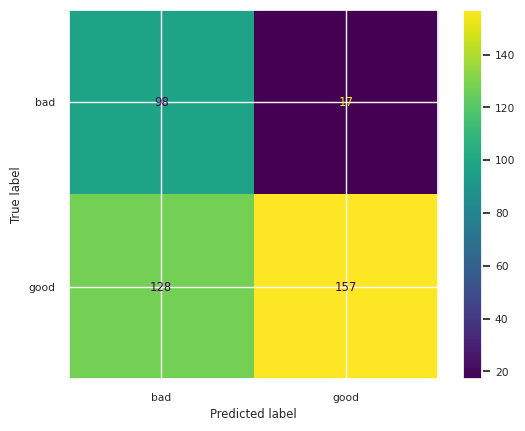

In [41]:
# Score Naive Bayes
# Predict probabilities on the test data

#may tune the threshold but not exactly necessary 

class_scoring(classNB_win, threshold=0.72) #I was manually chosing threshold to decrease cost. Write the code after for better tuning

# KNN
Metrics paper 
https://arxiv.org/pdf/cs/9701101.pdf


https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html

In [49]:
# tune parameters of KNN 
n_neighbors_options=[i for i in range(2,10)]
params = {
    'n_neighbors':n_neighbors_options,
    'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
    'weights': ['uniform','distance'],
    'metric': ['manhattan'],
}

# Create a based model
classKNN = KNeighborsClassifier()

# Instantiate the grid search model
grid_search = GridSearchCV(estimator = classKNN, param_grid = params, scoring=cost_sensitive_scorer)

grid_search.fit(train_X, train_y)
classKNN_param_win = grid_search.best_params_

classKNN_win = grid_search.best_estimator_ #returns classifier
print(classKNN_win)





KNeighborsClassifier(metric='manhattan', n_neighbors=2)


Classification metrics report for training test
              precision    recall  f1-score   support

         bad       0.66      1.00      0.79       185
        good       1.00      0.77      0.87       415

    accuracy                           0.84       600
   macro avg       0.83      0.88      0.83       600
weighted avg       0.89      0.84      0.84       600

Classification metrics report for validation test
              precision    recall  f1-score   support

         bad       0.46      0.73      0.57       115
        good       0.86      0.66      0.75       285

    accuracy                           0.68       400
   macro avg       0.66      0.70      0.66       400
weighted avg       0.75      0.68      0.69       400

**Model scoring**
Recall score:  0.73
Cost:  252


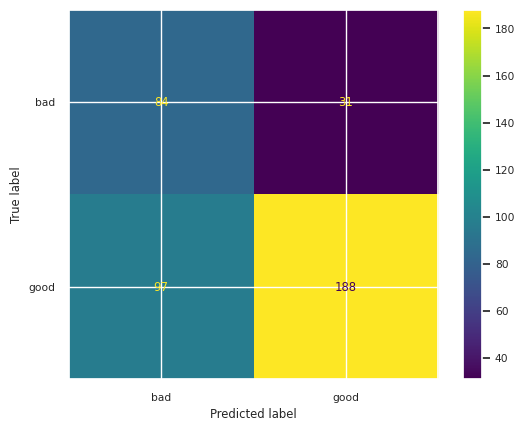

In [50]:
# Score KNN
class_scoring(classKNN_win)

# Random Forests
takes a lot of time to run with multiple forests (20-30 min)

In [51]:
#Random  Forests
classRF = RandomForestClassifier()

params = {
    'criterion': ['gini', 'entropy'], #The function to measure the quality of a split
    'max_depth': [2, 5, 7],
    'class_weight':[None, {"good":1, "bad":5},{"good":1, "bad":4},{"good":1, "bad":2} ]
}

grid_search = GridSearchCV(estimator = classRF, param_grid = params, scoring=cost_sensitive_scorer)
grid_search.fit(train_X, train_y)
# classRF_param_win = grid_search.best_params_
classRF_win = grid_search.best_estimator_ #returns classifier
print(classRF_win)



RandomForestClassifier(class_weight={'bad': 4, 'good': 1}, criterion='entropy',
                       max_depth=2)


Classification metrics report for training test
              precision    recall  f1-score   support

         bad       0.40      0.99      0.57       185
        good       0.99      0.33      0.49       415

    accuracy                           0.53       600
   macro avg       0.69      0.66      0.53       600
weighted avg       0.81      0.53      0.51       600

Classification metrics report for validation test
              precision    recall  f1-score   support

         bad       0.36      0.96      0.52       115
        good       0.95      0.31      0.46       285

    accuracy                           0.49       400
   macro avg       0.65      0.63      0.49       400
weighted avg       0.78      0.49      0.48       400

**Model scoring**
Recall score:  0.96
Cost:  223


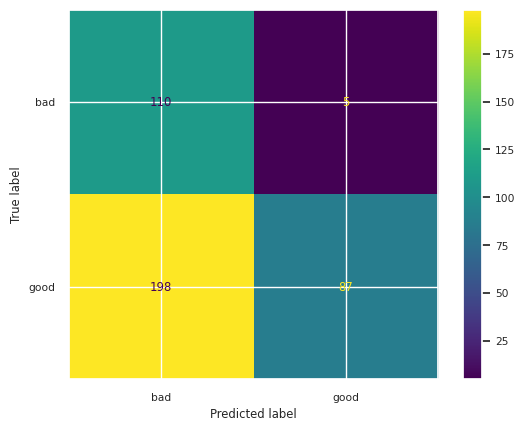

In [53]:
class_scoring(classRF_win)

# Result of estimation and conclusion

In [ ]:
https://scikit-learn.org/stable/auto_examples/model_selection/plot_cv_predict.html


https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc_crossval.html#sphx-glr-auto-examples-model-selection-plot-roc-crossval-py


## Notes
**Methods used for credit risk modelling:**  
* Logistic Regression:  
"Credit Risk Analysis Using Logistic Regression Model" by N. Nkoumbou, I. Hamadou, and A. Tamo-Tchakounte. International Journal of Scientific and Technology Research, Vol. 2, Issue 11, November 2013.  
"Credit Risk Assessment with Logistic Regression" by S. E. Kouki and M. Abrouk. International Journal of Economics, Commerce and Management, Vol. III, Issue 4, April 2015.  
* Decision Trees:  
"A Decision Tree-Based Approach for Credit Risk Evaluation" by L. Pei and J. Li. Expert Systems with Applications, Vol. 36, Issue 2, Part 1, March 2009.  
"Credit Scoring Models: A Comparison between Decision Tree Analysis and Neural Networks" by S. P. Kumar and S. S. S. Kumar. International Journal of Emerging Science and Engineering, Vol. 3, Issue 5, May 2015.  
* Random Forest:  
"Credit Risk Modeling using Random Forest" by P. Roy and A. Ghosh. Procedia Computer Science, Vol. 132, 2018.  
"Credit Scoring with a Random Forest Classifier" by D. Baena-García, J. del Campo-Ávila, R. Fidalgo, A. Bifet, R. Gavalda, and R. Morales-Bueno. Expert Systems with Applications, Vol. 42, Issue 11, July 2015.  
Support Vector Machines:
"Credit Scoring Models: A Comparison between Support Vector Machines and Multivariate Adaptive Regression Splines" by D. G. Luenberger and Y. Ye. Journal of Banking and Finance, Vol. 30, Issue 6, June 2006.  
"Credit Risk Assessment using Support Vector Machines and Random Forest" by S. K. Jha and S. S. S. Kumar. International Journal of Computer Applications, Vol. 102, Issue 6, September 2014.  
* Neural Networks:  
"A Comparison of Neural Networks and Linear Regression for Credit Risk Modeling" by A. G. de Oliveira, C. F. Joaquim, and F. S. M. de Oliveira. Expert Systems with Applications, Vol. 38, Issue 7, July 2011.  
"Credit Risk Analysis using Artificial Neural Networks" by R. Maqbool and A. Hussain. Journal of Applied Mathematics and Decision Sciences, Vol. 2014, Article ID 234101, 2014.  


** ENcoding**
* http://helios.mm.di.uoa.gr/~rouvas/ssi/sigkdd/sigkdd.vol3.1/barreca.pdf

